In [ ]:
from pathlib import Path
import sys

# Add the dot-pe directory to path for imports
sys.path.append(str(Path(__file__).parent.parent / "dot-pe"))

import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

lal.swig_redirect_standard_output_error(False)

# Import modules from the dot-pe directory
import sample_generation
import config
import waveform_creation

import pandas as pd
import numpy as np
from cogwheel import gw_utils

from cogwheel import utils
import json
import time
import matplotlib.pyplot as plt
from importlib import reload

reload(waveform_creation)


<module 'cogwheel.sampler_free.linear_free_waveform_creation' from '/Users/jonatahm/Work/GW/cogwheel-private/cogwheel/sampler_free/../../cogwheel/sampler_free/linear_free_waveform_creation.py'>

In [3]:
# select parameters for bank
n_intrinsic_samples = 2**10

q_min = 1/6
mchirp_min = 5
mchirp_max = 5.1
bank_name = 'test_bank'
# samples_bank_folder = Path(f'/BIGDATA/jonatahm/evidence_calculator/bank_mchirp_{mchirp_min}_{mchirp_max}')
# samples_bank_folder = Path(f'/BIGDATA/jonatahm/evidence_calculator/{bank_name}')
samples_bank_folder = Path('.')/ 'test_bank'
dataframe_path = samples_bank_folder / 'intrinsic_sample_bank.feather'

isg = sample_generation.IntrinsicSamplesGenerator()
# create folder if it does not exist
if samples_bank_folder.exists() is False:
    samples_bank_folder.mkdir()

In [4]:
start_time = time.time()
samples = isg.draw_intrinsic_samples_uniform_in_lnmchrip_lnq(
    n_intrinsic_samples, q_min, mchirp_min, mchirp_max,f_ref = 50.0)
samples.to_feather(dataframe_path)

end_time = time.time()
message = (f"{time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))} :"
           +f" func finished in {end_time - start_time:.2f} seconds.")
print(message)

2024-08-05 22:01:53 : func finished in 0.04 seconds.


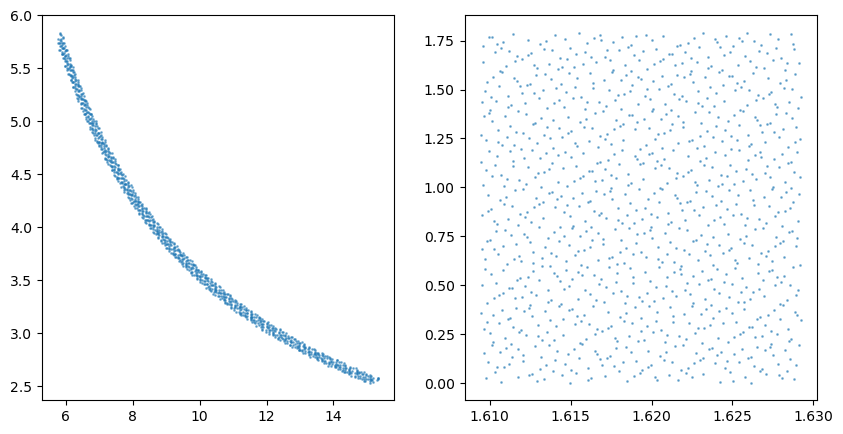

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(samples['m1'], samples['m2'], s=1, alpha=0.5)
mchirp =gw_utils.m1m2_to_mchirp(samples['m1'], samples['m2'])
q = np.log(samples['m1']/samples['m2'])
axs[1].scatter(np.log(mchirp), q, s=1, alpha=0.5)

In [ ]:
# # create config file

# bank_config_path = samples_bank_folder / 'bank_config.json'
# with open(bank_config_path, 'w', encoding='utf-8') as fp:
#     config_dict = {'fbin': config.DEFAULT_FBIN, 'f_ref':49.5}
#     json.dump(config_dict, fp, cls=utils.NumpyEncoder)

# waveform_creation.create_waveform_bank_from_samples(
#     samples_path=dataframe_path, bank_config_path = bank_config_path,
#     waveform_dir = dataframe_path.parent / 'waveforms',
#     n_blocks=None,
#     n_pool = 8, blocksize=64)


In [6]:
# create config file

bank_config_path = samples_bank_folder / 'bank_config.json'
with open(bank_config_path, 'w', encoding='utf-8') as fp:
    config_dict = {'fbin': config.DEFAULT_FBIN, 'f_ref':50.0}
    json.dump(config_dict, fp, cls=utils.NumpyEncoder)

waveform_creation.create_waveform_bank_from_samples(
    samples_path=dataframe_path, bank_config_path = bank_config_path,
    waveform_dir = dataframe_path.parent / 'waveforms',
    n_blocks=None,
    n_pool = 1, blocksize=64)


2024-08-05 22:02:31,692 - INFO - cogwheel.sampler_free.waveform_creation started at Mon Aug  5 22:02:31 2024
INFO:cogwheel.sampler_free.waveform_creation:cogwheel.sampler_free.waveform_creation started at Mon Aug  5 22:02:31 2024
2024-08-05 22:02:31,749 - INFO - block 0 started
INFO:cogwheel.sampler_free.waveform_creation:block 0 started
2024-08-05 22:02:31,750 - INFO - 0:0->63 started. Time passed 0.0583 seconds.
INFO:cogwheel.sampler_free.waveform_creation:0:0->63 started. Time passed 0.0583 seconds.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-08-05 22:02:32,910 - INFO - Block 0: indices 0->63 ended. Time passed 1.22 seconds.
INFO:cogwheel.sampler_free.waveform_creation:Block 0: indices 0->63 ended. Time passed 1.22 seconds.
2024-08-05 22:02:32,911 - INFO - block 1 started
INFO:cogwheel.sampler_free.waveform_creation:block 1 started
2024-08-05 22:02:32,912 - INFO - 1:64->127 started. Time passed 1.22 seconds.
INFO:cogwheel.sam